In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import os
import zipfile
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow import keras

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
from google.colab import files
drive.mount("/content/drive")

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"azkaprivanna","key":"841300ca256a5fda39dbb15657efb0a9"}'}

In [ ]:
!unzip -q /content/drive/MyDrive/Bangkit/dataset_disease-20240604T091501Z-001.zip

Dataset URL: https://www.kaggle.com/datasets/shubhamgoel27/dermnet
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 1.72G/1.72G [00:44<00:00, 39.5MB/s]
100% 1.72G/1.72G [00:44<00:00, 41.1MB/s]


In [ ]:
BATCH_SIZE = 32 # 32
IMG_SIZE = (256, 256)
IMG_SHAPE = IMG_SIZE + (3,)

In [ ]:
# Define the training and validation base directories
# DATASET_DIR = 'dermnet'
TRAINING_DIR='/content/train'
VALIDATION_DIR='/content/test'

In [ ]:
# print(f'DATASET_DIR: {DATASET_DIR}')
print(f'IMG_SIZE: {IMG_SIZE}')
print(f'IMG_SHAPE: {IMG_SHAPE}')
print(f'TRAINING_DIR: {TRAINING_DIR}')
print(f'VALIDATION_DIR: {VALIDATION_DIR}')

IMG_SIZE: (256, 256)
IMG_SHAPE: (256, 256, 3)
TRAINING_DIR: /content/train
VALIDATION_DIR: /content/test


In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator()

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=IMG_SIZE,
                                                      shuffle=True)

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator()

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=BATCH_SIZE,
                                                                class_mode='categorical',
                                                                target_size=IMG_SIZE)
  ### END CODE HERE
  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 10265 images belonging to 14 classes.
Found 2573 images belonging to 14 classes.


In [ ]:
train_generator.class_indices

{'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 0,
 'Atopic Dermatitis Photos': 1,
 'Cellulitis Impetigo and other Bacterial Infections': 2,
 'Eczema Photos': 3,
 'Light Diseases and Disorders of Pigmentation': 4,
 'Lupus and other Connective Tissue diseases': 5,
 'Nail Fungus and other Nail Disease': 6,
 'Poison Ivy Photos and other Contact Dermatitis': 7,
 'Scabies Lyme Disease and other Infestations and Bites': 8,
 'Seborrheic Keratoses and other Benign Tumors': 9,
 'Tinea Ringworm Candidiasis and other Fungal Infections': 10,
 'Urticaria Hives': 11,
 'Vasculitis Photos': 12,
 'Warts Molluscum and other Viral Infections': 13}

In [ ]:
labels = train_generator.class_indices.keys()
print(labels)

### **CALLBACK**

In [ ]:
# Define a Callback class that stops training once accuracy reaches 95.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95 and logs.get('val_accuracy')>0.95):
      print("\nReached 95.0% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks=myCallback()

### **MobileNetV3**

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)

base_model.trainable = False

12683000/12683000 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 128, 128, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 128, 128, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

In [ ]:
# Build Model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# Build Model
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = inputs # data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 8, 8, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_1  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 custom_layer (CustomLayer)  (None, 960)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              984064    
                                                                 
 dropout (Dropout)           (None, 1024)              0     

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
loss0, accuracy0 = model.evaluate(validation_generator)
print((loss0, accuracy0))

81/81 [==============================] - 128s 2s/step - loss: 2.7995 - accuracy: 0.0859
(2.799473762512207, 0.085891954600811)


In [ ]:
# Train the model.
EPOCH = 90

history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = EPOCH,
            callbacks = [callbacks])

Epoch 1/70
321/321 [==============================] - 793s 2s/step - loss: 2.3279 - accuracy: 0.2510 - val_loss: 2.0562 - val_accuracy: 0.3455
Epoch 2/70
321/321 [==============================] - 772s 2s/step - loss: 2.0912 - accuracy: 0.3259 - val_loss: 2.0067 - val_accuracy: 0.3653
Epoch 3/70
321/321 [==============================] - 754s 2s/step - loss: 2.0147 - accuracy: 0.3555 - val_loss: 1.9109 - val_accuracy: 0.3859
Epoch 4/70
321/321 [==============================] - 746s 2s/step - loss: 1.9685 - accuracy: 0.3722 - val_loss: 1.8573 - val_accuracy: 0.4205
Epoch 5/70
278/321 [========================>.....] - ETA: 1:22 - loss: 1.9289 - accuracy: 0.3949

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

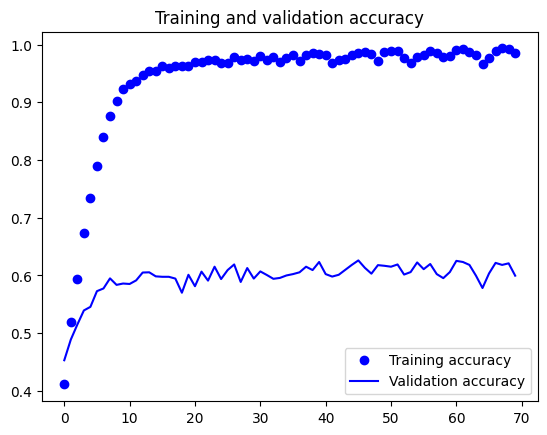

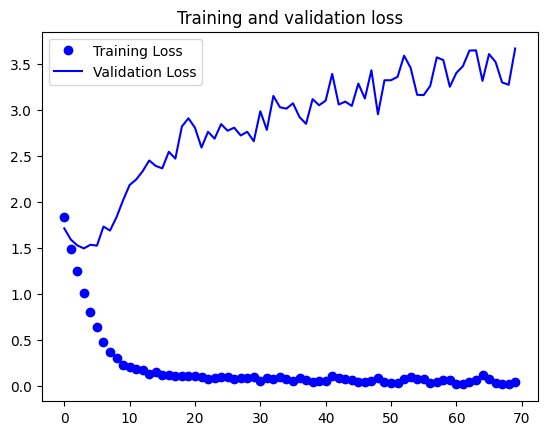

In [ ]:
def plot_hist(hist):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


plot_hist(history)

### **Fine Tuning**

In [ ]:
#unfreeze base_model
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  263


In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 8, 8, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_2  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1024)              984064    
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dense_4 (Dense)             (None, 256)               131328

In [ ]:
len(model.trainable_variables)

100

In [ ]:
fine_tune_epochs = 10
total_epochs =  EPOCH + fine_tune_epochs

history_fine = model.fit(train_generator,
                         validation_data = validation_generator,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch))

Epoch 71/80
321/321 [==============================] - 77s 199ms/step - loss: 0.1954 - accuracy: 0.9927 - val_loss: 3.1080 - val_accuracy: 0.9461
Epoch 72/80
321/321 [==============================] - 64s 198ms/step - loss: 0.1204 - accuracy: 0.9950 - val_loss: 2.9951 - val_accuracy: 0.9481
Epoch 73/80
321/321 [==============================] - 60s 186ms/step - loss: 0.0835 - accuracy: 0.9962 - val_loss: 3.0289 - val_accuracy: 0.9463
Epoch 74/80
321/321 [==============================] - 62s 192ms/step - loss: 0.0847 - accuracy: 0.9965 - val_loss: 3.1185 - val_accuracy: 0.9469
Epoch 75/80
321/321 [==============================] - 59s 184ms/step - loss: 0.0786 - accuracy: 0.9965 - val_loss: 3.2352 - val_accuracy: 0.9458
Epoch 76/80
321/321 [==============================] - 58s 182ms/step - loss: 0.0597 - accuracy: 0.9973 - val_loss: 3.2759 - val_accuracy: 0.9477
Epoch 77/80
321/321 [==============================] - 58s 179ms/step - loss: 0.0624 - accuracy: 0.9974 - val_loss: 3.3795 -

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

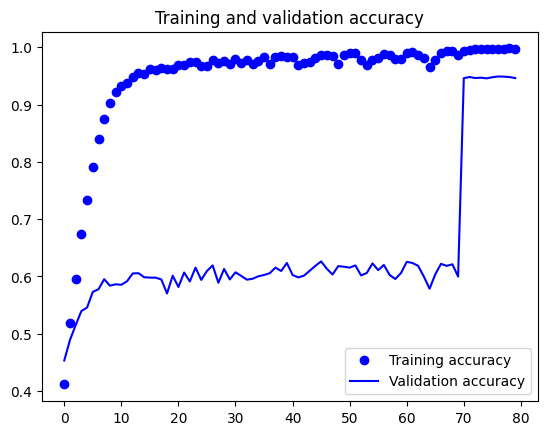

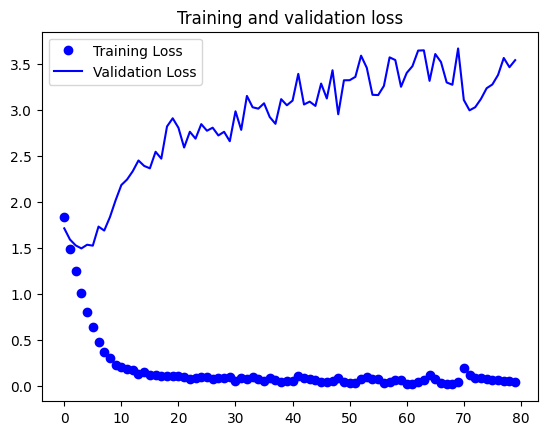

In [ ]:
plot_hist(history_fine)

### **Evaluation & Testing**

In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print('Test accuracy :', accuracy)

81/81 [==============================] - 12s 141ms/step - loss: 3.5403 - accuracy: 0.9463
Test accuracy : 0.9462828040122986


### **SAVE MODEL**

In [ ]:
model.save("model_mobilenet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('saved_model/my_model_mobil2')

In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 102.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 112.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 45.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
   

In [ ]:
! tensorflowjs_converter --input_format=tf_saved_model \
                         --output_node_names='MobilenetV3/Predictions/Reshape_1' \
                         --saved_model_tags=serve \
                         ./path/to/save/model \
                         ./output/destination/path

2024-05-31 12:46:29.096154: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
!zip -r /content/output/destination/path /content/output/destination/path

  adding: content/tfjs_model/ (stored 0%)
  adding: content/tfjs_model/group1-shard5of5.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard3of5.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard4of5.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard2of5.bin (deflated 7%)
  adding: content/tfjs_model/model.json (deflated 95%)
  adding: content/tfjs_model/group1-shard1of5.bin (deflated 7%)


In [ ]:
from google.colab import files
files.download("/content/output/destination/path.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!tensorflowjs_converter --input_format=keras /content/model_mobilenet.h5 /content/model_mobilenet.json


Traceback (most recent call last):
  File "C:\Users\Clara Carissa\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Clara Carissa\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Clara Carissa\AppData\Local\Programs\Python\Python39\Scripts\tensorflowjs_converter.exe\__main__.py", line 4, in <module>
  File "C:\Users\Clara Carissa\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflowjs\__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "C:\Users\Clara Carissa\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflowjs\converters\__init__.py", line 21, in <module>
    from tensorflowjs.converters.converter import convert
  File "C:\Users\Clara Carissa\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflowjs\converters\converter.py", line 38, in <modu

In [ ]:
! tensorflowjs_converter --input_format=tf_saved_model \
                         --output_node_names='MobilenetV3/Predictions/Reshape_1' \
                         --saved_model_tags=serve \
                         ./input/savedmodel/path \
                         ./output/destination/path

In [ ]:
model_json = model.to_json()
with open("model4.json", "w") as json_file:
    json_file.write(model_json)
# model.save_weights("model3.bin")
print("Saved model .......")

Saved model .......
